# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [456]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [457]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

In [458]:
config_file = 'config/config_commodities_long.json'

### Import Configurations

In [459]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [460]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [461]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor(path=config['dataset']['path'])

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [462]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(ticker_attribute=config['dataset']['ticker_attribute'])

In [463]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


In [464]:
etfs_unique.Segment.value_counts()

Equity: U.S. MLPs                                            25
Commodities: Broad Market                                    21
Commodities: Precious Metals Gold                            12
Equity: U.S. Energy                                          11
Commodities: Energy Crude Oil                                10
Commodities: Agriculture                                      7
Equity: Global Gold Miners                                    7
Inverse Commodities: Energy Crude Oil                         7
Leveraged Commodities: Energy Crude Oil                       5
Equity: Global Water                                          5
Equity: Global Metals & Mining                                5
Commodities: Precious Metals Silver                           5
Commodities: Energy                                           4
Inverse Commodities: Precious Metals Gold                     4
Commodities: Energy Natural Gas                               3
Equity: U.S. Oil & Gas Exploration & Pro

When reading the dataset, read training data and test data at the same time. Then, discard the tickers with null values, therefore ensuring we only remain with tickers common to both periods. Split in training and validation later.

In [465]:
dataset = data_processor.read_tickers_prices(tickers=tickers,
                                             initial_date=config['dataset']['training_initial_date'],
                                             final_date=config['dataset']['testing_final_date'],
                                             data_source=config['dataset']['data_source']
                                            )

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for BATT
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for XLEY

Unable to download 3.686635944700461% of the ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [466]:
df_prices_with_null, df_prices = data_processor.dict_to_df(dataset, config['dataset']['nan_threshold'])
print(df_prices_with_null.shape)
print(df_prices.shape)

From now on, we are only considering 141 ETFs
(1488, 209)
(1488, 141)


**Show removed ETFs with insufficient information**

In [467]:
null_values = df_prices_with_null.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AMJL    1079
AMU      124
AMUB     968
AMZA     670
AOIL    1485
ATMP     277
BAR     1405
BCD     1298
BCI     1298
BMLP    1249
COMB    1361
COMG    1336
CRAK     892
DGAZ       4
DRIP     836
DWT     1222
EMLP      97
ENFR     440
FENY     434
FRAK       9
FTGC     433
FTXN    1168
GASX     965
GDXS     762
GDXX     788
GLDI     247
GLDW    1257
GOAU    1360
GUSH     834
IMLP     231
        ... 
MLPQ    1011
MLPX     379
MLPZ    1016
OILD    1247
OILK    1171
OILU    1247
OILX    1016
OUNZ     574
PDBC     696
PLTM     511
PPLN    1420
SGDJ     793
SGDM     614
SILJ     207
SLVO     301
TAGS      38
TBLU    1267
TPYP     884
UCIB     927
UGAZ       4
USAI    1476
USOD    1368
USOI    1357
USOU    1368
UWT     1222
WTID    1240
WTIU    1240
YMLI     257
YMLP      28
ZMLP     496
Length: 68, dtype: int64

**Split data in training and validation**

We split the dataframe in training and validation and from now on we work with the training set

In [468]:
train_mask = (df_prices.index <= config['dataset']['training_final_date'])
test_mask = (df_prices.index >= config['dataset']['testing_initial_date'])
df_prices_train = df_prices[train_mask]
df_prices_test = df_prices[test_mask]

In [469]:
# nomenclature to facilitate
df_prices = df_prices_train

**Obtain returns**

In [470]:
df_returns = data_processor.get_return_series(df_prices)
df_returns.head()

,AGF,AGQ,AMJ,AMLP,BAL,BCM,BDD,BNO,BOIL,BOM,...,USLV,USO,USV,VDE,WEAT,XES,XLE,XME,XOP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-03,0.005370,-0.041085,0.001246,-0.000590,0.018015,0.004859,0.053864,0.019182,-0.029028,-0.050427,...,-0.058870,0.012389,-0.037793,0.017502,-0.002691,0.016789,0.017620,0.017201,0.018397,0.041582
2012-02-06,0.011752,0.002151,0.001743,0.002361,-0.004174,0.002418,-0.011852,0.016311,0.051570,0.023402,...,0.003347,-0.006917,-0.001890,0.011908,-0.002248,0.016245,0.011956,-0.003347,0.020927,0.001947
2012-02-07,-0.004752,0.033344,0.000497,0.001374,-0.023470,0.005262,0.005247,-0.001235,-0.062544,-0.005277,...,0.050876,0.016609,-0.031566,0.005230,-0.010816,0.000000,0.005160,-0.015023,0.011212,-0.037901
2012-02-08,-0.012202,-0.014217,-0.000745,-0.000597,-0.003090,0.000436,0.007457,0.009765,-0.033359,-0.010610,...,-0.022222,0.002372,0.003259,-0.002509,-0.008656,0.001310,-0.003377,-0.004665,0.001213,0.013131
2012-02-09,0.010204,-0.008913,0.003977,0.002985,-0.034613,0.001308,0.023686,0.010405,0.024314,-0.028597,...,-0.010755,0.007624,0.000000,0.000000,-0.020221,-0.008636,0.000135,-0.004146,0.000346,0.006979


In [471]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  9870.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [472]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[2.26196659e+08 2.93429314e-02 1.31390559e-02 8.90767000e-03
 6.18869524e-03 5.28464511e-03 3.85622988e-03 2.53055283e-03
 2.22681047e-03 1.61712697e-03 1.41048792e-03 1.00753516e-03
 9.69614125e-04 8.21199961e-04 7.70053654e-04 7.55557858e-04
 7.31108520e-04 7.09838349e-04 6.54769321e-04 5.82003194e-04]


In [473]:
N_PRIN_COMPONENTS = 15#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [474]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 18
Pairs to evaluate: 172


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [475]:
print(counts)

13    14
7      7
2      6
3      5
0      4
1      4
10     4
4      3
8      3
15     3
16     2
9      2
6      2
5      2
11     2
12     2
14     2
17     2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [476]:
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  10
Clusters discovered: 14
Pairs to evaluate: 601
Silhouette score  0.10953052530552675

Number of components:  11
Clusters discovered: 19
Pairs to evaluate: 314
Silhouette score  0.09760378084593825

Number of components:  12
Clusters discovered: 20
Pairs to evaluate: 274
Silhouette score  0.0668760330276949

Number of components:  13
Clusters discovered: 19
Pairs to evaluate: 257
Silhouette score  0.02357308597949276

Number of components:  14
Clusters discovered: 18
Pairs to evaluate: 172
Silhouette score  -0.00977859025269532

Number of components:  15
Clusters discovered: 18
Pairs to evaluate: 172
Silhouette score  0.011771864827165447

Number of components:  16
Clusters discovered: 16
Pairs to evaluate: 144
Silhouette score  -0.026853361805004586

Number of components:  17
Clusters discovered: 15
Pairs to evaluate: 140
Silhouette score  -0.045289126348032636

Number of components:  18
Clusters discovered: 15
Pairs to evaluate: 133
Silhouette score  -0.0571

**Fundamental analysis for clusters**

In [477]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                                            Segment
156    AMJ                                  Equity: U.S. MLPs
154   AMLP                                  Equity: U.S. MLPs
185   FILL  Equity: Global Oil & Gas Exploration & Production
175    FXN                                Equity: U.S. Energy
171    IEO    Equity: U.S. Oil & Gas Exploration & Production
176    IEZ        Equity: U.S. Oil & Gas Equipment & Services
160    IXC                              Equity: Global Energy
163    IYE                                Equity: U.S. Energy
206   MLPG                                  Equity: U.S. MLPs
159   MLPI                                  Equity: U.S. MLPs
215   MLPY                                  Equity: U.S. MLPs
162    OIH      Equity: Global Oil & Gas Equipment & Services
192   PSCE                                Equity: U.S. Energy
188    PXE    Equity: U.S. Oil & Gas Exploration & Production
183    PXI                                Equity: U.S. Ene

**Visualizing with t-sne**

In [478]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

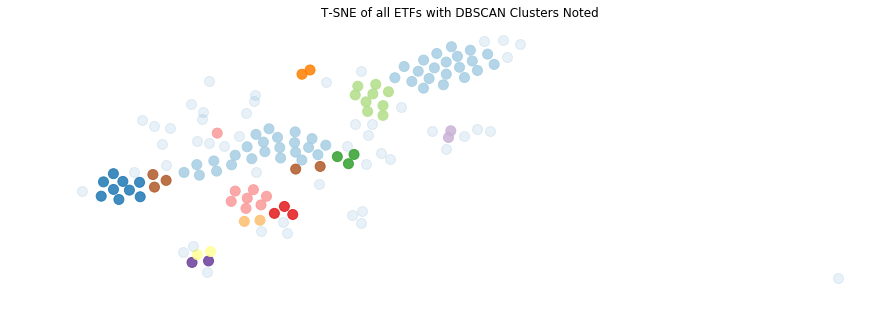

In [479]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

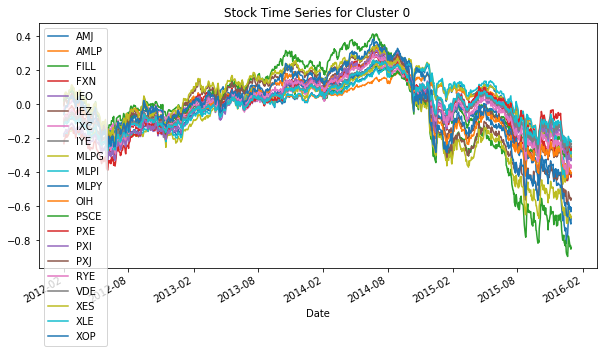

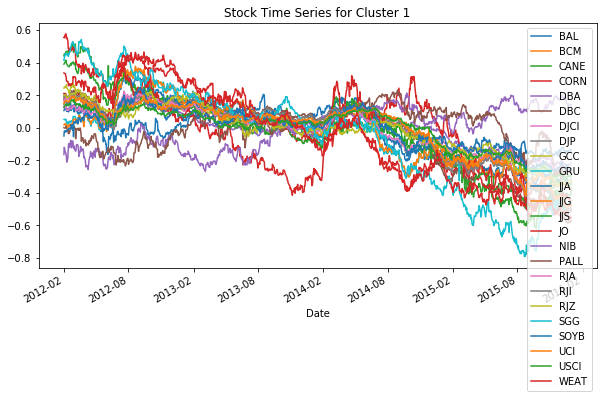

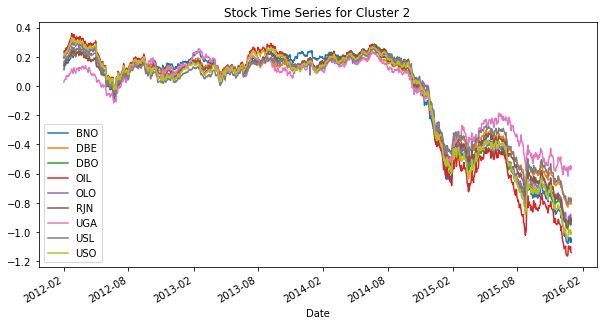

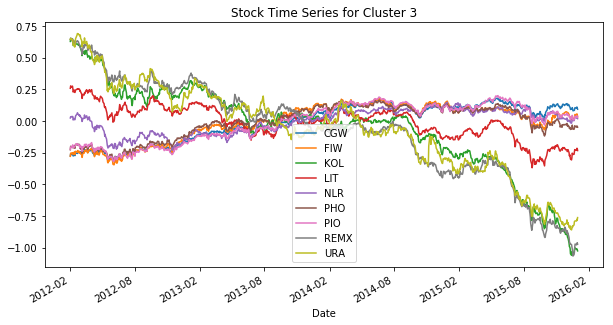

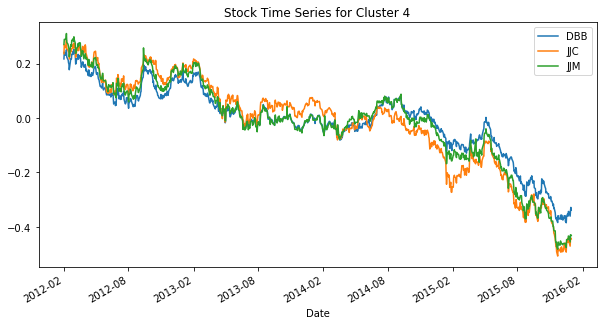

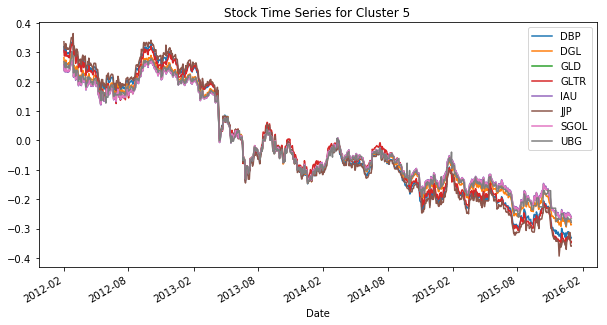

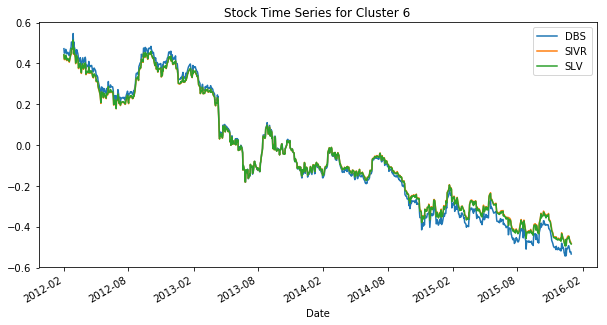

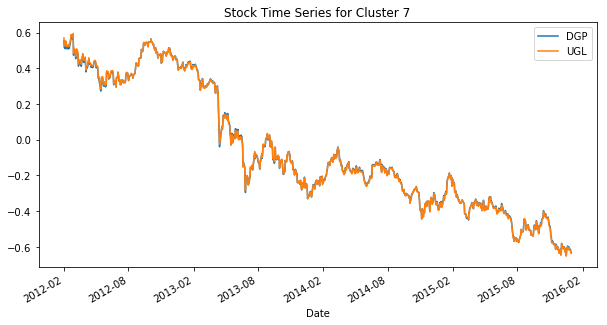

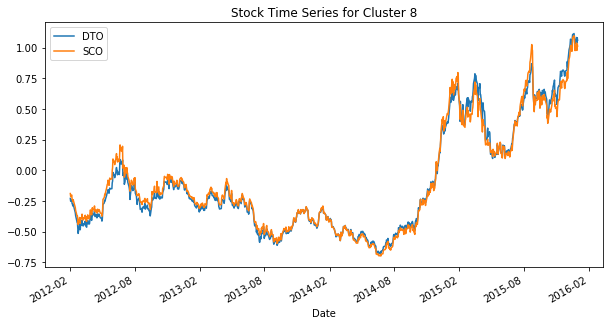

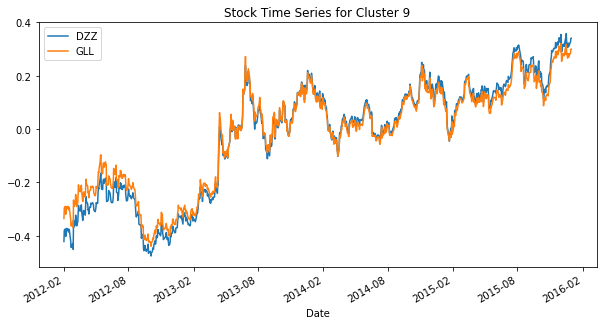

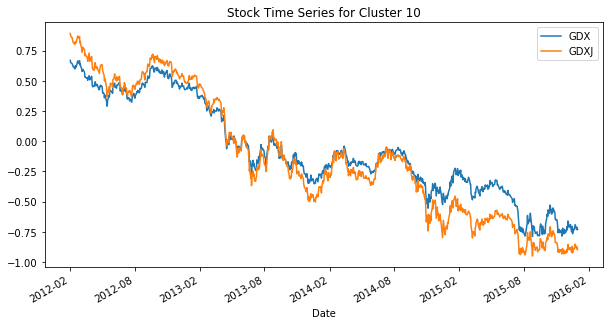

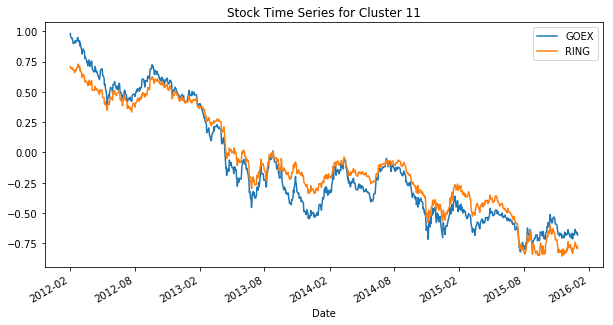

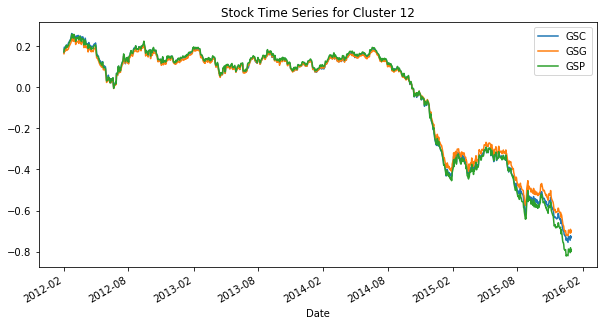

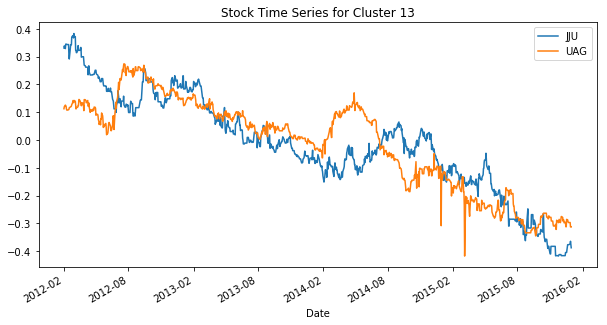

In [480]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices[symbols].mean())
    series = np.log(df_prices[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [481]:
pairs, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices,
                                                            pricing_df_test=df_prices_test,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 123 pairs
The pairs contain 78 unique tickers


In [482]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

**Applying Bollinger Bands**

In [483]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter,
                                                                                         test_mode=False
                                                                                         )



FILL,IEZ
Considered 4 years
APR -0.010205002523790085
Sharpe 0.02311253779076851


FILL,MLPY
Considered 4 years
APR 0.03204996053201614
Sharpe 0.2547928852149264


FILL,OIH
Considered 4 years
APR 0.05863670138867905
Sharpe 0.4134037318961687


FILL,PXJ
Considered 4 years
APR 0.1119660102991562
Sharpe 0.7040783855917789


FILL,XOP
Considered 4 years
APR 0.25785459105985864
Sharpe 1.2833681519547275


FXN,IXC
Considered 4 years
APR 0.011420059650959269
Sharpe 0.1762328993978691


IEO,IYE
Considered 4 years
APR 0.0199958985551294
Sharpe 0.3424696219970032


IEO,MLPG
Considered 4 years
APR 0.05907425524959864
Sharpe 0.3714129801534251


IEO,VDE
Considered 4 years
APR -0.07285510550264185
Sharpe -1.3408326334276528


IEO,XLE
Considered 4 years
APR 0.06274746874623016
Sharpe 1.1304161422817884


IEZ,IXC
Considered 4 years
APR 0.13079023081288188
Sharpe 1.2797003725952836


IEZ,XOP
Considered 4 years
APR 0.1093504433596959
Sharpe 0.8210615661660219


IXC,MLPY
Considered 4 years
APR 0.282852

Considered 4 years
APR -0.24787550501746725
Sharpe -0.7300595042144541


JJA,RJA
Considered 4 years
APR 0.05780101343698818
Sharpe 1.0201364282999628


JJA,SOYB
Considered 4 years
APR 0.2998647191607984
Sharpe 1.742026593116897


JJA,WEAT
Considered 4 years
APR 0.20972693583044233
Sharpe 1.295554556644296


JJG,JJS
Considered 4 years
APR 0.6000158848910706
Sharpe 1.763142868522315


JJG,WEAT
Considered 4 years
APR 0.28538566571107804
Sharpe 1.8584170917342697


JJS,RJA
Considered 4 years
APR 0.4193617870002375
Sharpe 1.7223877464379445


JJS,SOYB
Considered 4 years
APR 0.5009803489846072
Sharpe 1.4215116179626863


JO,RJA
Considered 4 years
APR -0.11858694933572622
Sharpe -0.31239909454168885


JO,RJI
Considered 4 years
APR 0.47762924110821947
Sharpe 1.5755013832462688


JO,SOYB
Considered 4 years
APR -0.27431262812179635
Sharpe -0.6188105799768157


JO,UCI
Considered 4 years
APR -0.08377826039591552
Sharpe -0.18613764487253184


JO,USCI
Considered 4 years
APR 0.05069808063230785
Sharp

Considered 4 years
APR 0.10819505749966507
Sharpe 0.7880948610235485


DGP,UGL
Considered 4 years
APR 0.023085069113054635
Sharpe 1.0356338975931405


DTO,SCO
Considered 4 years
APR -0.1973576153444313
Sharpe -1.344214879143997


DZZ,GLL
Considered 4 years
APR -0.025051670543573823
Sharpe -0.5385310183997137


GDX,GDXJ
Considered 4 years
APR 0.2731138896438765
Sharpe 1.783902008713709


GOEX,RING
Considered 4 years
APR -0.14609404105659562
Sharpe -0.7448775543284712


JJU,UAG
Considered 4 years
APR 0.05096206223712629
Sharpe 0.31635687893241266


**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.5858069702654105


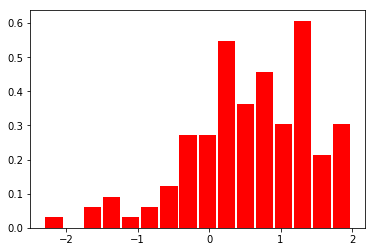

In [484]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

In [485]:
n_years= round(len(df_prices)/240)
total_roi_bollinger = np.mean(cum_returns_bollinger)
anual_roi_bollinger = ((1+(total_roi_bollinger/100))**(1/float(n_years))-1)*100
print('ROI: ', total_roi_bollinger)
print('Anual return:', anual_roi_bollinger)

ROI:  9.385426897827388
Anual return: 2.2680244302165864


**Applying the Kalman filter based strategy**

In [486]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)



FILL,IEZ
APR 0.20846987354258228
Sharpe 2.9783665533323096


FILL,MLPY
APR 0.4080645031228771
Sharpe 2.0633840953536686


FILL,OIH
APR 0.41350869887556785
Sharpe 3.7081202500182817


FILL,PXJ
APR 1.1898980242110246
Sharpe 5.492581206550735


FILL,XOP
APR 0.30220556338257487
Sharpe 2.567355591086912


FXN,IXC
APR 0.0639450406143609
Sharpe 0.8437471707430214


IEO,IYE
APR -0.008410857475593447
Sharpe -0.39942670727526397


IEO,MLPG
APR 0.4613784099008076
Sharpe 1.8966864635100196


IEO,VDE
APR -0.035228378904231916
Sharpe -1.4567862867375276


IEO,XLE
APR -0.019420108110015488
Sharpe -0.5899678646768027


IEZ,IXC
APR 0.008577097813659895
Sharpe 0.1872474623267559


IEZ,XOP
APR 0.10543652781373725
Sharpe 1.0304226709867357


IXC,MLPY
APR 0.14128062466122038
Sharpe 0.9321494122282996


IXC,XOP
APR 0.23245946548455465
Sharpe 2.000526156728648


IYE,PXI
APR 0.013438822783322646
Sharpe 0.3204231196512411


IYE,VDE
APR -0.01873014465547229
Sharpe -0.9981855522108922


MLPG,XLE
APR 0.26289287

Sharpe Ratio Results: 
Average result:  1.6954867929105866


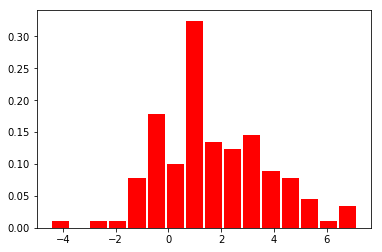

In [487]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))

In [488]:
n_years= round(len(df_prices)/240)
total_roi_kalman = np.mean(cum_returns_kalman)
annual_roi_kalman = ((1+(total_roi_kalman/100))**(1/float(n_years))-1)*100
print('ROI: ', total_roi_kalman)
print('Annual return:', annual_roi_kalman)

ROI:  41.515415851231424
Annual return: 9.06890121515509


## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

We start by applying the trading dtrategy on the pairs identified on the training set:

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [489]:
n_years_test = round(len(df_prices_test)/240)

### Approach 1: Keeping every pair

**Bollinger Bands Out-of-Sample**

In [490]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )



FILL,IEZ
Considered 2 years
APR 0.08294816262976634
Sharpe 0.7946119424228076


FILL,MLPY
Considered 2 years
APR -0.11616848334763463
Sharpe -0.8412914001933319


FILL,OIH
Considered 2 years
APR 0.02951918527416253
Sharpe 0.32356771719328314


FILL,PXJ
Considered 2 years
APR 0.10733905062144533
Sharpe 0.9376905242973367


FILL,XOP
Considered 2 years
APR -0.067144115051196
Sharpe -0.5951903229313916


FXN,IXC
Considered 2 years
APR 0.04141392080464912
Sharpe 0.81271175472655


IEO,IYE
Considered 2 years
APR -0.015830808605404312
Sharpe -0.30671684932315074


IEO,MLPG
Considered 2 years
APR -0.1342318443114564
Sharpe -0.8672754332850301


IEO,VDE
Considered 2 years
APR -0.05525896318766266
Sharpe -1.6164496701929254


IEO,XLE
Considered 2 years
APR -0.009767167770484031
Sharpe -0.2013286782182763


IEZ,IXC
Considered 2 years
APR -0.01567362237196157
Sharpe -0.20308136826970863


IEZ,XOP
Considered 2 years
APR 0.19901668628638003
Sharpe 1.641033806900548


IXC,MLPY
Considered 2 years
AP

Considered 2 years
APR -0.125217452980954
Sharpe -0.8456173145587174


JJA,JO
Considered 2 years
APR 0.031741080885939965
Sharpe 0.34833107611745834


JJA,RJA
Considered 2 years
APR 0.06481528795053326
Sharpe 1.1502764956743157


JJA,SOYB
Considered 2 years
APR 0.09231100586799701
Sharpe 1.062034287185721


JJA,WEAT
Considered 2 years
APR -0.09566468628566016
Sharpe -0.9147946921930731


JJG,JJS
Considered 2 years
APR -0.0597503549331877
Sharpe -0.3007352547638784


JJG,WEAT
Considered 2 years
APR -0.05527562415733367
Sharpe -0.7968343634176546


JJS,RJA
Considered 2 years
APR -0.2431412623422019
Sharpe -2.0610223525783478


JJS,SOYB
Considered 2 years
APR -0.26164597982912563
Sharpe -1.666897155662762


JO,RJA
Considered 2 years
APR -0.023922041285644013
Sharpe -0.2059666727939666


JO,RJI
Considered 2 years
APR -0.022822621520594333
Sharpe -0.11310298397038619


JO,SOYB
Considered 2 years
APR -0.10994309308557482
Sharpe -0.5448497868767836


JO,UCI
Considered 2 years
APR 0.0609630550

/Users/simaomoraessarmento/Dropbox/IST/Tese/code/PairsTrading/class_Trader.py:195: RuntimeWarning: invalid value encountered in double_scalars
  apr = ((np.prod(1.+ret))**(time_in_market/len(ret)))-1


Considered 2 years
APR -0.019243442947559752
Sharpe 0.04073279868356802


OLO,UGA
Considered 2 years
APR 0.1685464572363693
Sharpe 0.8725792207736357


RJN,UGA
Considered 2 years
APR 0.0040205266730608535
Sharpe 0.09148549390696104


UGA,USO
Considered 2 years
APR -0.12419992766162125
Sharpe -1.2836295301164342


CGW,NLR
Considered 2 years
APR 0.03151893878715195
Sharpe 0.5560034971891976


CGW,URA
Considered 2 years
APR 0.04458547574817029
Sharpe 0.3897580811189775


FIW,NLR
Considered 2 years
APR -0.14738371873423262
Sharpe -1.949148634888736


KOL,LIT
Considered 2 years
APR 0.058387133714488115
Sharpe 0.4715370826037677


KOL,REMX
Considered 2 years
APR -0.1888753926541813
Sharpe -1.7006407328974198


KOL,URA
Considered 2 years
APR -0.4283708603762838
Sharpe -2.2215930590051105


NLR,PHO
Considered 2 years
APR 0.023822420396385935
Sharpe 0.33364509739666565


NLR,PIO
Considered 2 years
APR -0.07115618661188505
Sharpe -0.9331188739263515


NLR,REMX
Considered 2 years
APR -0.170356875

In [491]:
print('Average result: ', np.mean(sharpe_results_bollinger_test))
total_roi_bollinger_test = np.mean(cum_returns_bollinger_test)
anual_roi_bollinger_test = ((1+(total_roi_bollinger_test/100))**(1/float(n_years_test))-1)*100
print('ROI: ', total_roi_bollinger_test)
print('Anual return:', anual_roi_bollinger_test)

Average result:  -0.12288253624895035
ROI:  -4.390735730723011
Anual return: -2.220010089345492


**Kalman Out-of-Sample**

In [492]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)



FILL,IEZ
APR 0.061410689774755944
Sharpe 1.1318293195698101


FILL,MLPY
APR 0.417273105147675
Sharpe 2.263894927588043


FILL,OIH
APR 0.13726588444348087
Sharpe 1.7873733039639206


FILL,PXJ
APR 0.5737735132570829
Sharpe 3.2673035346292587


FILL,XOP
APR 0.27046765778204285
Sharpe 2.7245358728498843


FXN,IXC
APR 0.13603257950444236
Sharpe 1.4561272469292945


IEO,IYE
APR -0.008434999542231036
Sharpe -0.2467972508354492


IEO,MLPG
APR 0.511275118397414
Sharpe 2.3853189470019363


IEO,VDE
APR -0.012006709070708554
Sharpe -0.4577572854181218


IEO,XLE
APR -0.0024088790734938526
Sharpe -0.023032282958774


IEZ,IXC
APR -0.0192729639295951
Sharpe -0.20208110086680156


IEZ,XOP
APR 0.06384603552962842
Sharpe 0.735508541923302


IXC,MLPY
APR 0.46653214663205866
Sharpe 2.6477878311814265


IXC,XOP
APR 0.0662064305558614
Sharpe 0.6794487559174822


IYE,PXI
APR 0.02187920906798202
Sharpe 0.3202885450846489


IYE,VDE
APR -0.004953376695450151
Sharpe -1.1823556470057603


MLPG,XLE
APR 0.57396332

In [493]:
print('Average result: ', np.mean(sharpe_results_kalman_test))
total_roi_kalman_test = np.mean(cum_returns_kalman_test)
anual_roi_kalman_test = ((1+(total_roi_kalman_test/100))**(1/float(n_years_test))-1)*100
print('ROI: ', total_roi_kalman_test)
print('Anual return:', anual_roi_kalman_test)

Average result:  0.9677277543133533
ROI:  17.058966176608298
Anual return: 8.193791955272678


### Approach 2: Keeping only pairs that had positive returns in the training period

**Bollinger Strategy**

In [494]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
positive_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
positive_pairs = [pairs[i] for i in positive_pairs_indices.flatten()]

In [495]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(positive_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )



FILL,IEZ
Considered 2 years
APR 0.08294816262976634
Sharpe 0.7946119424228076


FILL,MLPY
Considered 2 years
APR -0.11616848334763463
Sharpe -0.8412914001933319


FILL,OIH
Considered 2 years
APR 0.02951918527416253
Sharpe 0.32356771719328314


FILL,PXJ
Considered 2 years
APR 0.10733905062144533
Sharpe 0.9376905242973367


FILL,XOP
Considered 2 years
APR -0.067144115051196
Sharpe -0.5951903229313916


FXN,IXC
Considered 2 years
APR 0.04141392080464912
Sharpe 0.81271175472655


IEO,IYE
Considered 2 years
APR -0.015830808605404312
Sharpe -0.30671684932315074


IEO,MLPG
Considered 2 years
APR -0.1342318443114564
Sharpe -0.8672754332850301


IEO,XLE
Considered 2 years
APR -0.009767167770484031
Sharpe -0.2013286782182763


IEZ,IXC
Considered 2 years
APR -0.01567362237196157
Sharpe -0.20308136826970863


IEZ,XOP
Considered 2 years
APR 0.19901668628638003
Sharpe 1.641033806900548


IXC,MLPY
Considered 2 years
APR -0.10918240800792645
Sharpe -1.0534904089920705


IXC,XOP
Considered 2 years
AP

Considered 2 years
APR -0.010898789148528931
Sharpe -0.037126438316395866


RJZ,WEAT
Considered 2 years
APR 0.08452800310009034
Sharpe 0.8038092092921916


SGG,SOYB
Considered 2 years
APR -0.24432100765662834
Sharpe -1.0969596569967592


SOYB,UCI
Considered 2 years
APR -0.07771804290005102
Sharpe -0.6097966624803098


SOYB,USCI
Considered 2 years
APR -0.09992096628895941
Sharpe -1.0381121503202526


SOYB,WEAT
Considered 2 years
APR -0.16255115752250782
Sharpe -1.043262687647596


BNO,DBE
Considered 2 years
APR -0.007705888615026524
Sharpe -0.2370513950653773


BNO,RJN
Considered 2 years
APR 0.1409251475865081
Sharpe 1.304433511374918


BNO,UGA
Considered 2 years
APR -0.04904387266871357
Sharpe -0.4489050829733891


DBE,OLO
Considered 2 years
APR -0.04544016371547088
Sharpe -0.13697748281335465


DBE,UGA
Considered 2 years
APR -0.05286588769834233
Sharpe -0.7488888683238056


DBO,UGA
Considered 2 years
APR -0.09175950077532635
Sharpe -0.9854959545631268


OIL,UGA
Considered 2 years
APR 

/Users/simaomoraessarmento/Dropbox/IST/Tese/code/PairsTrading/class_Trader.py:195: RuntimeWarning: invalid value encountered in double_scalars
  apr = ((np.prod(1.+ret))**(time_in_market/len(ret)))-1


Considered 2 years
APR -0.019243442947559752
Sharpe 0.04073279868356802


OLO,UGA
Considered 2 years
APR 0.1685464572363693
Sharpe 0.8725792207736357


RJN,UGA
Considered 2 years
APR 0.0040205266730608535
Sharpe 0.09148549390696104


UGA,USO
Considered 2 years
APR -0.12419992766162125
Sharpe -1.2836295301164342


KOL,REMX
Considered 2 years
APR -0.1888753926541813
Sharpe -1.7006407328974198


KOL,URA
Considered 2 years
APR -0.4283708603762838
Sharpe -2.2215930590051105


NLR,PHO
Considered 2 years
APR 0.023822420396385935
Sharpe 0.33364509739666565


NLR,PIO
Considered 2 years
APR -0.07115618661188505
Sharpe -0.9331188739263515


NLR,REMX
Considered 2 years
APR -0.1703568752127359
Sharpe -1.7909013485346528


NLR,URA
Considered 2 years
APR 0.005735268168616248
Sharpe 0.11181704961254363


REMX,URA
Considered 2 years
APR -0.1831623553442424
Sharpe -0.7963273124640429


DBB,JJM
Considered 2 years
APR 0.0051385653589290925
Sharpe 0.10181711813114666


DBP,DGL
Considered 2 years
APR -0.005

In [496]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  -0.11395079448396084
avg_total_roi:  -5.342567500746814
avg_annual_roi:  -2.7079486806588116
44.329896907216494 % of the pairs had positive returns


**Kalman Strategy**

In [497]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
positive_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
positive_pairs = [pairs[i] for i in positive_pairs_indices.flatten()]

In [498]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             positive_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)



FILL,IEZ
APR 0.061410689774755944
Sharpe 1.1318293195698101


FILL,MLPY
APR 0.417273105147675
Sharpe 2.263894927588043


FILL,OIH
APR 0.13726588444348087
Sharpe 1.7873733039639206


FILL,PXJ
APR 0.5737735132570829
Sharpe 3.2673035346292587


FILL,XOP
APR 0.27046765778204285
Sharpe 2.7245358728498843


FXN,IXC
APR 0.13603257950444236
Sharpe 1.4561272469292945


IEO,MLPG
APR 0.511275118397414
Sharpe 2.3853189470019363


IEZ,IXC
APR -0.0192729639295951
Sharpe -0.20208110086680156


IEZ,XOP
APR 0.06384603552962842
Sharpe 0.735508541923302


IXC,MLPY
APR 0.46653214663205866
Sharpe 2.6477878311814265


IXC,XOP
APR 0.0662064305558614
Sharpe 0.6794487559174822


IYE,PXI
APR 0.02187920906798202
Sharpe 0.3202885450846489


MLPG,XLE
APR 0.5739633223468983
Sharpe 2.926624921656505


OIH,XOP
APR 0.09893692618139771
Sharpe 1.2090121431311387


PSCE,PXJ
APR 0.11882891162965659
Sharpe 1.668605660479528


PSCE,XOP
APR 0.09653717511676785
Sharpe 0.9355311278128194


PXI,RYE
APR -0.03176317616553459
Sh

In [499]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.3132975447389243
avg_total_roi:  19.86436699396052
avg_annual_roi:  9.482586283828965
76.28865979381443 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be intrested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [500]:
def pairs_overlap(pairs, p_value_threshold, min_zero_crossings, min_half_life, hurst_threshold):
    """
    This function receives the pairs identified in the training set, and returns a list of the pairs
    which are still cointegrated in the test set.
    """
    pairs_overlapped = []
    pairs_overlapped_index = []
    
    for index,pair in enumerate(pairs):
        # get consituents
        X = pair[2]['X_test']
        Y = pair[2]['Y_test']
        # check if pairs is valid
        series_name = X.name
        X = sm.add_constant(X)
        results = sm.OLS(Y, X).fit()
        X = X[series_name]
        b = results.params[X.name]
        spread = Y - b * X
        stats = series_analyser.check_for_stationarity(pd.Series(spread, name='Spread'))
        
        if stats['p_value'] < p_value_threshold: # verifies required pvalue
            hl = series_analyser.calculate_half_life(spread)
            if hl >= min_half_life: # verifies required half life
                zero_cross = series_analyser.zero_crossings(spread)
                if zero_cross >= min_zero_crossings: # verifies required zero crossings
                    hurst_exponent = series_analyser.hurst(spread)
                    if hurst_exponent < hurst_threshold: # verifies hurst exponent
                        pairs_overlapped.append(pair)
                        pairs_overlapped_index.append(index)

    return pairs_overlapped, pairs_overlapped_index

In [501]:
pairs_overlapped, pairs_overlapped_index = pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

20 of the 123 pairs identified in the training set are also cointegrated in the test set


In [502]:
positive_pairs_overlapped, positive_pairs_overlapped_index = pairs_overlap(positive_pairs, config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(positive_pairs_overlapped), len(positive_pairs)))

13 of the 97 pairs with positive returns identified in the training set are also cointegrated in the test set


### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration es a very important predictor of future returns.

We also compare the average performance of the two groups.

*Still cointegrated*

In [523]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in positive_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in positive_pairs_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)

Average result:  1.3363417505265678
avg_total_roi:  8.306334837855852
avg_annual_roi:  4.070329507432557
84.61538461538461 % of the pairs had positive returns


*Not cointegrated anymore*

In [524]:
# distribution for pairs which were cointegrated in train but not in test
positive_pairs_not_overlapped_index = [i for i in np.arange(0,len(positive_pairs))\
                                       if i not in positive_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in positive_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in positive_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Average result:  1.3097311795575035
avg_total_roi:  21.653110065738627
avg_annual_roi:  10.29646869493992
75.0 % of the pairs had positive returns


Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return (84.6% vs 75%). Furthermore,what we can conclude from the results above is that being cointegrated did not imply that those pairs generated higher returns. In fact, the average annual return is higher for the pairs that were not found to be cointegrated in the testing period (4.07% vs 10.3%)

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [503]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# Apply PCA
X_test, explained_variance_test = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns_test)
# Apply clustering
clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
    series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                 config['clustering']['min_samples'],
                                 X_test, df_returns_test)
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            n_clusters=len(counts_test),
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))

Clusters discovered: 15
Pairs to evaluate: 110
Found 15 pairs
The pairs contain 20 unique tickers
3 of the 15 pairs identified in the test set are also cointegrated in the training set


Let's see if the pairs identified in the test period lead indeed to improved results:

In [504]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)



BCM,DBC
APR 0.1790100176460545
Sharpe 4.747373605265871


BCM,GSG
APR 0.06721445066157905
Sharpe 2.9602543529199004


BCM,GSP
APR 0.24803026224554792
Sharpe 2.819959039082678


DBC,RJI
APR 0.012190099978125701
Sharpe 1.0731175001086246


DJCI,GSG
APR 0.08096287006362868
Sharpe 2.0657028093356655


DBO,USL
APR 0.04082948407320908
Sharpe 1.0530045992975632


USL,USO
APR 0.09451039775990422
Sharpe 2.208912492907465


FIW,PHO
APR 0.007561538467360407
Sharpe 0.3374495330420948


CORN,WEAT
APR -0.024093588751246453
Sharpe -0.8115470070126871


DBA,GRU
APR 0.5025836238963965
Sharpe 4.026818878531257


DBA,RJA
APR -0.0022817417904235082
Sharpe -0.43768435940711076


DBA,SOYB
APR 0.06113570437020588
Sharpe 1.11412683149096


RJA,SOYB
APR 0.015303283262433798
Sharpe 1.9794899514861803


IEO,PXE
APR 0.09204179251491618
Sharpe 1.7974634752663317


PXE,RYE
APR 0.03861679868362544
Sharpe 0.616794614847521
Average result:  1.7034157544774875
avg_total_roi:  9.403149264044172
avg_annual_roi:  4.5959

As we would expect, the results in the testset would have been way better with the pairs identified on that same period.

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

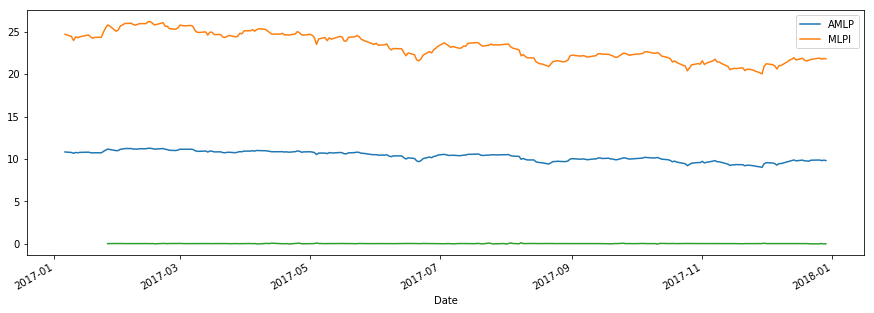

In [466]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [380]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

-0.04480324434678721


However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [376]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.021426798923804273


We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [108]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
negative_pairs_indices = np.argwhere(sharpe_results_kalman < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

9 out of 50 pairs turned out to be non-profitable


Let's get some more information on the non-profitable pairs:

In [109]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

[('IEO', 'IYE'),
 ('BAL', 'GCC'),
 ('BAL', 'USCI'),
 ('DJP', 'GCC'),
 ('BNO', 'UGA'),
 ('DBE', 'UGA'),
 ('UGA', 'USL'),
 ('UGA', 'USO'),
 ('CORN', 'JJG')]

To what clusters do these pairs belong?

In [110]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

Pair ('IEO', 'IYE') belongs to cluster 0
Pair ('BAL', 'GCC') belongs to cluster 1
Pair ('BAL', 'USCI') belongs to cluster 1
Pair ('DJP', 'GCC') belongs to cluster 1
Pair ('BNO', 'UGA') belongs to cluster 3
Pair ('DBE', 'UGA') belongs to cluster 3
Pair ('UGA', 'USL') belongs to cluster 3
Pair ('UGA', 'USO') belongs to cluster 3
Pair ('CORN', 'JJG') belongs to cluster 5


How do the statistics rank?

In [111]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive trades,negative_trades,sharpe_result
0,CORN,GRU,-3.404058,0.010821,104,28,0.419100,19,14,7.874875
1,RJN,USL,-2.988861,0.035948,114,35,0.439754,16,9,7.050578
2,RJA,SOYB,-4.474279,0.000219,98,21,0.360609,20,22,5.984475
3,RJN,USO,-3.351293,0.012736,95,37,0.439245,16,6,5.897631
4,JJC,JJM,-3.097372,0.026748,80,22,0.329256,24,15,5.699725
5,GRU,WEAT,-3.909307,0.001967,106,37,0.466337,16,7,5.586175
6,DBO,RJN,-3.365444,0.012195,115,30,0.427794,17,10,5.496269
7,DGP,UGL,-3.205752,0.019654,73,14,0.335867,39,28,3.986749
8,JJA,WEAT,-3.117105,0.025313,74,54,0.444761,7,7,3.866423
9,DJCI,GCC,-3.167705,0.021932,81,21,0.361562,27,14,3.568772


In [112]:
df.half_life.mean()

42.28

In [113]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Half-life vs Sharpe Ratio correlation:  -0.4545065959240087
Zero crossings vs Sharpe Ratio correlation:  0.41834257704466227
p-value vs Sharpe Ratio correlation:  0.02552538602418196
t-statistic vs Sharpe Ratio correlation:  0.09585827383877676
Hurst exponent vs Sharpe Ratio correlation  -0.07104130200064852


Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

# What if we haven't done any clustering?

**All against all** - *comparing against the simplest strategy*

In [201]:
no_cluster_series = pd.Series(0,index = etfs_pricing.columns)
total_pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 273 pairs
The pairs contain 41 unique tickers
Found 273 pairs


Bollinger Bands:

In [203]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_boll_aaa, cum_returns_boll_aaa, performance_boll_aaa = trader.apply_bollinger_strategy(total_pairs_all_a_all,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



ALTY,DBV
APR -0.019690076598853357
Sharpe -0.37666046873915465


ALTY,DIVA
APR -0.025647640984403308
Sharpe -0.6268695474526955


ALTY,FLAT
APR 0.08703113849382382
Sharpe 2.030807685607455


ALTY,FUT
APR -0.00956969317643086
Sharpe -0.24988167683679713


ALTY,MRGR
APR -0.03981804664306354
Sharpe -1.0451248382719696


ALTY,SIZ
APR 0.04559781673716912
Sharpe 0.9427153906928085


ALTY,STPP
APR -0.04367292586973193
Sharpe -0.5331008817168248


ALTY,TVIX
APR 0.15845242756404643
Sharpe 1.115245313399877


ALTY,UVXY
APR 0.1815796270931438
Sharpe 1.2097981203596972


BTAL,DIVY
APR 0.017862582442937258
Sharpe 0.5720161966008018


BTAL,FUT
APR 0.029607195121189145
Sharpe 0.7547881999532214


BTAL,JPHF
APR 0.013638947462838669
Sharpe 0.448227225572819


CHEP,DIVA
APR 0.04564442310806638
Sharpe 0.8075868719931734


CHEP,DIVY
APR 0.023734801604629485
Sharpe 0.8278376545038248


CHEP,FTLS
APR -0.05475313592423159
Sharpe -0.5285461968372713


CHEP,FUT
APR 0.07843386895838855
Sharpe 0.95411644317309

APR 0.00018772807011280257
Sharpe 0.02526143334356859


DIVA,RINF
APR -0.045554115023159425
Sharpe -0.9852954618389087


DIVA,RLY
APR -0.01896471359405061
Sharpe -0.4051598950197042


DIVA,SIZ
APR 0.04684659395991919
Sharpe 0.9843676193258001


DIVA,STPP
APR 0.08510554058169872
Sharpe 1.4779415908917648


DIVA,TVIX
APR 0.04146312860638357
Sharpe 0.5933366926315745


DIVA,UVXY
APR 0.05205618217328323
Sharpe 0.734026628385942


DIVA,VEGA
APR -0.05642056614856672
Sharpe -1.564124480081488


DIVA,VIIX
APR 0.11407931714193853
Sharpe 1.9963207888977776


DIVA,VIXM
APR 0.10549016666101863
Sharpe 1.729224592760924


DIVA,VIXY
APR 0.10904664755240456
Sharpe 1.8996972497442384


DIVA,WTMF
APR 0.044035992860706585
Sharpe 1.149769501876805


DIVA,XVZ
APR 0.05254693458806314
Sharpe 1.122031104003971


DIVA,ZIV
APR -0.08165630755618969
Sharpe -1.4003938728604428


DIVY,DYB
APR -0.024569195016881595
Sharpe -0.9748186210390113


DIVY,FMF
APR -0.03682071366157491
Sharpe -1.2561063428888681


DIVY,MNA
A

APR -0.013264208326657423
Sharpe -0.2819939172430328


FUT,GAA
APR 0.03096986960422865
Sharpe 0.9009555733700528


FUT,HTUS
APR 0.02303278694396793
Sharpe 0.7388046003734902


FUT,JPHF
APR 0.04081425011189066
Sharpe 1.572016704331324


FUT,MCRO
APR 0.00807815069318174
Sharpe 0.297958642354598


FUT,MNA
APR -0.0033786845322384407
Sharpe -0.11191925393761408


FUT,MOM
APR 0.04525950443613991
Sharpe 1.2925014335620562


FUT,QAI
APR 0.01793785247566615
Sharpe 0.7177366576557209


FUT,QED
APR -0.05365952144185904
Sharpe -2.052228008273042


FUT,QLS
APR -0.015262384741230317
Sharpe -0.4599074662859895


FUT,QMN
APR 0.007898676507078983
Sharpe 0.33744439145744165


FUT,SIZ
APR -0.011701496822161261
Sharpe -0.27763578578786585


FUT,SVXY
APR -0.008735844000838489
Sharpe -0.18056608916994585


FUT,TVIX
APR -0.03348761812613865
Sharpe -0.701280205107946


FUT,UVXY
APR -0.03202798418065267
Sharpe -0.6713121003841697


FUT,VEGA
APR 0.01130011645109752
Sharpe 0.36898880399202194


FUT,VIIX
APR -0.0

APR -0.028810665304430882
Sharpe -1.2156909622290077


MNA,QMN
APR -0.033148208661512135
Sharpe -1.6304147225551633


MNA,SIZ
APR 0.011458415759262097
Sharpe 0.40091680518302564


MNA,STPP
APR -0.01104767493098513
Sharpe -0.35664442759613796


MNA,TVIX
APR -0.23912276535886245
Sharpe -1.199030258589216


MNA,UVXY
APR -0.28672377462857124
Sharpe -1.5504418831513092


MNA,VEGA
APR -0.024743814592359192
Sharpe -1.0502076686306336


MNA,VIIX
APR 0.03360939211634384
Sharpe 0.8987617039516559


MNA,VIXY
APR 0.031560052556113716
Sharpe 0.8232540108156807


MNA,XVZ
APR 0.022780270316132167
Sharpe 0.7999483838926853


MNA,ZIV
APR -0.05309244144173597
Sharpe -1.7050645354947593


MOM,QMN
APR -0.06338503702109777
Sharpe -2.1737886560424227


MOM,TVIX
APR -0.17228317345691957
Sharpe -0.5554809421259133


MOM,UVXY
APR -0.1987058073885467
Sharpe -0.7160483875003189


MOM,VEGA
APR -0.015207803828720112
Sharpe -0.3069874371281602


MRGR,QAI
APR -0.0218363270668418
Sharpe -1.098622853595885


MRGR,QED


APR 0.12781076619854614
Sharpe 0.967694694316533


TVIX,VIXM
APR -0.030107075046490128
Sharpe -0.16383633581407728


TVIX,XVZ
APR 0.11805659011942726
Sharpe 0.5190886067989029


UVXY,VEGA
APR 0.11959576123471938
Sharpe 0.9102157036559749


UVXY,VIXM
APR -0.0444710409582616
Sharpe -0.27552171159037575


UVXY,XVZ
APR 0.44063357459775543
Sharpe 1.0367498642915272


VEGA,VIXM
APR 0.09727167638303924
Sharpe 1.2950686313414943


VIIX,ZIV
APR -0.08401676285230242
Sharpe -0.8172407043595594


VIXY,ZIV
APR -0.13274753935170802
Sharpe -1.3632337600605549


Sharpe Ratio Results (considering entire universe): 
Average result:  -0.2182626320695486


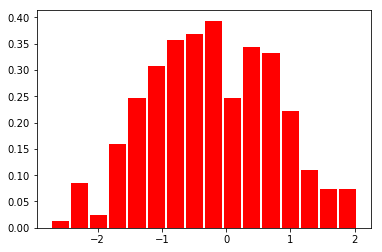

In [205]:
print('Sharpe Ratio Results (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_boll_aaa, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_boll_aaa))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


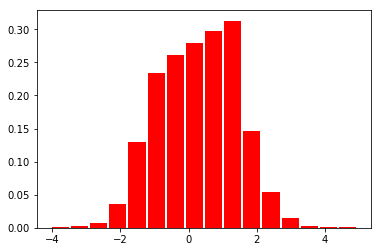

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))